In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import optuna
import numpy as np
from scipy import stats

# Set the Optuna logger to output only WARNING and higher levels
optuna.logging.set_verbosity(optuna.logging.WARNING)

sns.set_theme()
sns.set_context("notebook")
%load_ext autoreload
%autoreload 2

/Users/user/anaconda3/envs/GIGACOW/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dtype_dict = {
    'Date': 'str',
    'FarmName_Pseudo': 'str',
    'SE_Number': 'str',
    'Age': 'Int64',
    'DailyYield': 'float',
    'PreviousDailyYield': 'float',
    'DailyYieldChange': 'float',
    'DaysInMilk': 'float',
    'YearSeason': 'str',
    'LactationNumber': 'float',
    'ExpectedYield': 'float',
    'NormalizedDailyYield': 'float',
    'NormalizedDailyYieldChange': 'float',
    'HeatStress': 'Int64',
    'Temp15Threshold': 'Int64',
    'HW': 'Int64',
    'cum_HW': 'Int64',
    'MeanTemperature': 'float',
    'MeanTHI_adj': 'float',
    'FarmHeatStressMilkProduction': 'float'
}

milk_data = pd.read_csv('../Data/MergedData/XGBMilkFarmYieldData.csv', dtype=dtype_dict)
milk_data['Date'] = pd.to_datetime(milk_data['Date'], format='%Y-%m-%d')
milk_data.head(-5)

,Date,FarmName_Pseudo,SE_Number,Age,LactationNumber,DaysInMilk,YearSeason,DailyYield,PreviousDailyYield,DailyYieldChange,ExpectedYield,NormalizedDailyYield,NormalizedDailyYieldChange,HeatStress,Temp15Threshold,HW,cum_HW,MeanTemperature,MeanTHI_adj,FarmHeatStressMilkProduction
0,2022-01-01,a624fb9a,SE-064c0cec-1189,3095,7.0,191.0,2022-1,30.77,0.00,0.00,29.739372,1.034655,0.000000,0,0,0,0,-3.025000,28.012944,NaN
1,2022-01-02,a624fb9a,SE-064c0cec-1189,3096,7.0,192.0,2022-1,48.22,30.77,17.45,29.692059,1.624003,0.587699,0,0,0,0,-0.279167,32.898193,NaN
2,2022-01-03,a624fb9a,SE-064c0cec-1189,3097,7.0,193.0,2022-1,30.53,48.22,-17.69,29.644756,1.029862,-0.596733,0,0,0,0,2.033333,36.760487,NaN
3,2022-01-04,a624fb9a,SE-064c0cec-1189,3098,7.0,194.0,2022-1,42.26,30.53,11.73,29.597463,1.427825,0.396318,0,0,0,0,0.066667,31.939524,NaN
4,2022-01-05,a624fb9a,SE-064c0cec-1189,3099,7.0,195.0,2022-1,38.49,42.26,-3.77,29.550181,1.302530,-0.127580,0,0,0,0,-3.700000,26.498206,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487083,2023-06-03,f454e660,SE-fcdf259d-0044-0,4150,10.0,347.0,2023-3,12.67,15.75,-3.08,11.811455,1.072687,-0.260764,0,1,0,0,12.666667,53.132530,NaN
487084,2023-06-04,f454e660,SE-fcdf259d-0044-0,4151,10.0,348.0,2023-3,22.31,12.67,9.64,11.750492,1.898644,0.820391,0,1,0,0,13.079167,56.726870,NaN
487085,2023-06-05,f454e660,SE-fcdf259d-0044-0,4152,10.0,349.0,2023-3,12.84,22.31,-9.47,11.689810,1.098393,-0.810107,0,1,0,0,14.237500,58.482418,NaN
487086,2023-06-06,f454e660,SE-fcdf259d-0044-0,4153,10.0,350.0,2023-3,9.47,12.84,-3.37,11.629408,0.814315,-0.289783,0,1,0,0,15.345833,60.546358,NaN


## Farm a624fb9a

In [3]:
# Filter data for a specific farm
farm = 'a624fb9a'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Filter data for HeatStress condition
data_heatstress = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()

# Ensure the features are float type and scale them
features_to_scale = ['MeanTemperature', 'MeanTHI_adj']
data_heatstress[features_to_scale] = data_heatstress[features_to_scale].astype(float)
scaler = StandardScaler()
data_heatstress[features_to_scale] = scaler.fit_transform(data_heatstress[features_to_scale])

# Define the feature combinations
feature_combinations = [
    ['MeanTemperature', 'HW'],
    ['MeanTemperature', 'cum_HW'],
    ['MeanTHI_adj', 'HW'],
    ['MeanTHI_adj', 'cum_HW']
]

# List to store model instances and results for each cow
models = []
results = []

# Function to optimize hyperparameters using Optuna
def objective(trial, train_data, target):
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
    }

    model = xgb.XGBRegressor(**param)
    scores = cross_val_score(model, train_data, target, cv=3, scoring='neg_mean_squared_error')
    mse = -scores.mean()
    return mse

# Function to find the best feature combination
def find_best_feature_combination(data, feature_combinations):
    best_features = None
    lowest_mse = float('inf')

    for features in feature_combinations:
        # Filter valid features
        valid_features = [feat for feat in features if data[feat].std() > 0]
        
        if not valid_features:
            continue

        X_val = data[valid_features].astype(np.float64).values
        y_val = data['NormalizedDailyYield'].astype(np.float64).values

        # Optimize hyperparameters using Optuna
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, X_val, y_val), n_trials=50)
        mean_cv_score = study.best_value

        if mean_cv_score < lowest_mse:
            lowest_mse = mean_cv_score
            best_features = valid_features

    return best_features, lowest_mse

# Find the best feature combination
best_features, best_mse = find_best_feature_combination(data_heatstress, feature_combinations)
print(f"Best features: {best_features}, with MSE: {best_mse}")

# Function to fit XGBoost model and calculate yield change for each cow
def fit_xgboost_and_calculate_yield_change(data, features):
    cow_ids = data['SE_Number'].unique()
    yield_changes = {}

    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]
        
        # Check if there's enough data for the cow
        if len(cow_data) < 10:  # Minimum number of data points for training
            continue

        # Split the data into train and test sets
        train_data, test_data = train_test_split(cow_data, test_size=0.3, random_state=42)
        
        # Define the feature and target
        X_train = train_data[features]
        y_train = train_data['NormalizedDailyYield']
        X_test = test_data[features]
        y_test = test_data['NormalizedDailyYield']
        
        # Optimize hyperparameters using Optuna
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=50)
        best_params = study.best_params

        # Train final model using the best parameters
        best_model = xgb.XGBRegressor(**best_params)
        best_model.fit(X_train, y_train)
        
        # Store the model instance
        models.append(best_model)
        
        # Predictions and evaluation on the test set
        y_pred = best_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        
        # Estimation of average milk production during heat stress
        average_production_heat_stress = y_pred.mean()
        
        # Calculate the reduction compared to baseline
        reduction = ((baseline_mean - average_production_heat_stress) / baseline_mean)
        
        # Store results
        results.append({
            'SE_Number': cow,
            'MSE': mse,
            'Yield HeatStress': average_production_heat_stress,
            'Reduction': reduction
        })
    
    return results

# Calculate the baseline mean for NormalizedDailyYield
baseline_mean = daily_farm_data['NormalizedDailyYield'].mean()

# Fit the model and calculate yield changes for all cows using the best features
yield_changes_heatstress = fit_xgboost_and_calculate_yield_change(data_heatstress, best_features)

# Create results DataFrame
results_df = pd.DataFrame(yield_changes_heatstress)

results_df

Best features: ['MeanTemperature', 'cum_HW'], with MSE: 0.03995352675689138


,SE_Number,MSE,Yield HeatStress,Reduction
0,SE-064c0cec-1189,0.026187,1.015964,-0.019081
1,SE-30dc5787-1389,0.040267,0.953841,0.043232
2,SE-30dc5787-1396,0.043286,0.962668,0.034377
3,SE-30dc5787-1402,0.072713,0.908837,0.088374
4,SE-a624fb9a-1039,0.043270,0.917038,0.080148
...,...,...,...,...
128,SE-a624fb9a-1490,0.027119,0.872946,0.124376
129,SE-a624fb9a-1491,0.036440,0.955559,0.041509
130,SE-a624fb9a-1493,0.220941,1.064163,-0.067429
131,SE-a624fb9a-1496,0.017340,0.919614,0.077564


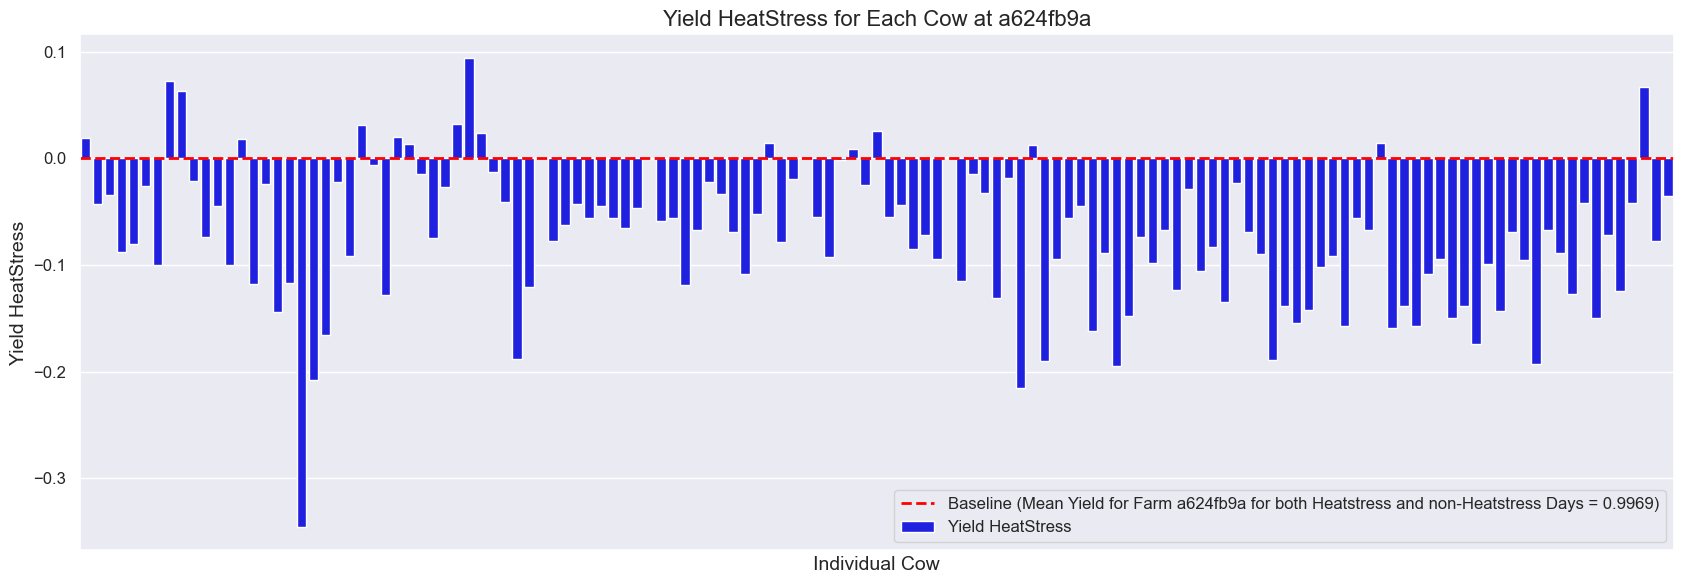

In [4]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['Deviation from Baseline'], color='blue', label='Yield HeatStress')

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for Farm {farm} for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Yield HeatStress', fontsize=14)
plt.title(f'Yield HeatStress for Each Cow at {farm}', fontsize=16)


plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

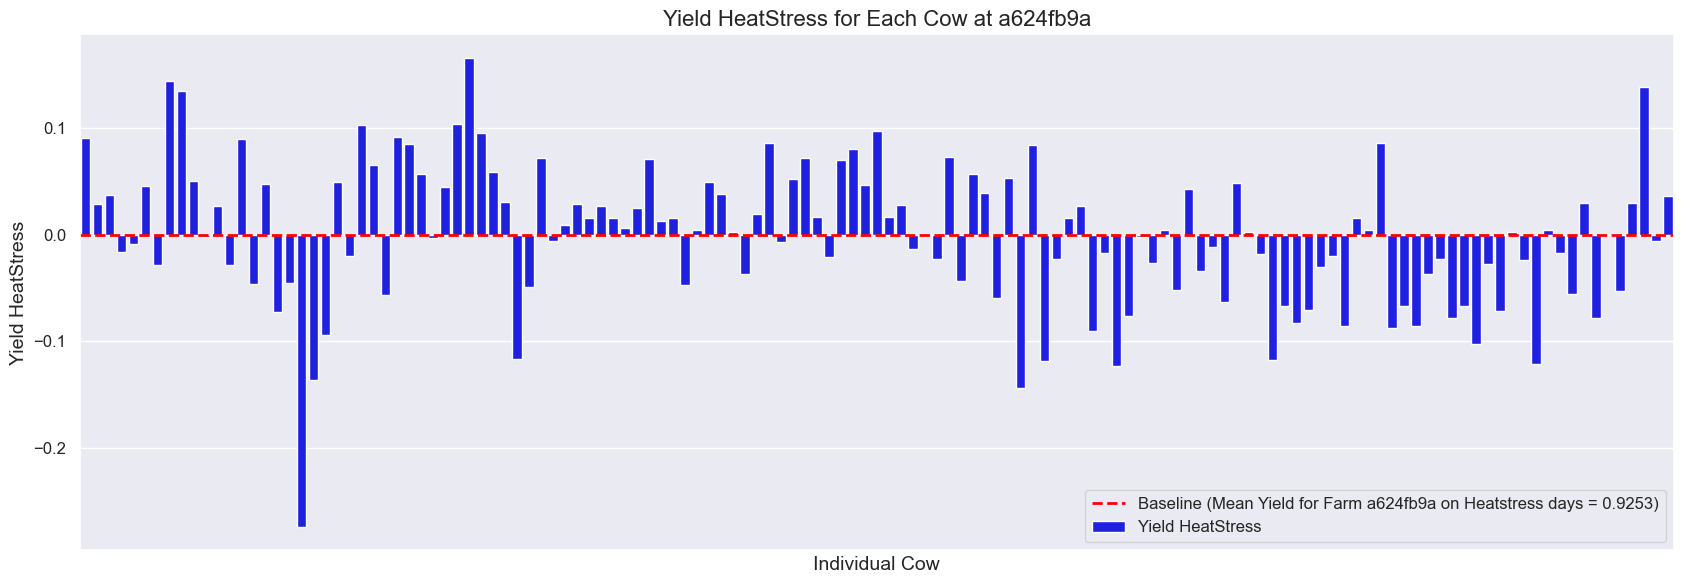

In [5]:
# Calculate the baseline (mean yield change)
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress['FarmHeatStressMilkProduction'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['Deviation from Baseline'], color='blue', label='Yield HeatStress')

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for Farm {farm} on Heatstress days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Yield HeatStress', fontsize=14)
plt.title(f'Yield HeatStress for Each Cow at {farm}', fontsize=16)


plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

## Farm 5c06d92d

In [ ]:
# Filter data for a specific farm
farm = '5c06d92d'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Filter data for HeatStress condition
data_heatstress = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()

# Ensure the features are float type and scale them
features_to_scale = ['MeanTemperature', 'MeanTHI_adj']
data_heatstress[features_to_scale] = data_heatstress[features_to_scale].astype(float)
scaler = StandardScaler()
data_heatstress[features_to_scale] = scaler.fit_transform(data_heatstress[features_to_scale])

# Define the feature combinations
feature_combinations = [
    ['MeanTemperature', 'HW'],
    ['MeanTemperature', 'cum_HW'],
    ['MeanTHI_adj', 'HW'],
    ['MeanTHI_adj', 'cum_HW']
]

# List to store model instances and results for each cow
models = []
results = []

# Function to optimize hyperparameters using Optuna
def objective(trial, train_data, target):
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
    }

    model = xgb.XGBRegressor(**param)
    scores = cross_val_score(model, train_data, target, cv=3, scoring='neg_mean_squared_error')
    mse = -scores.mean()
    return mse

# Function to find the best feature combination
def find_best_feature_combination(data, feature_combinations):
    best_features = None
    lowest_mse = float('inf')

    for features in feature_combinations:
        # Filter valid features
        valid_features = [feat for feat in features if data[feat].std() > 0]
        
        if not valid_features:
            continue

        X_val = data[valid_features].astype(np.float64).values
        y_val = data['NormalizedDailyYield'].astype(np.float64).values

        # Optimize hyperparameters using Optuna
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, X_val, y_val), n_trials=50)
        mean_cv_score = study.best_value

        if mean_cv_score < lowest_mse:
            lowest_mse = mean_cv_score
            best_features = valid_features

    return best_features, lowest_mse

# Find the best feature combination
best_features, best_mse = find_best_feature_combination(data_heatstress, feature_combinations)
print(f"Best features: {best_features}, with MSE: {best_mse}")

# Function to fit XGBoost model and calculate yield change for each cow
def fit_xgboost_and_calculate_yield_change(data, features):
    cow_ids = data['SE_Number'].unique()
    yield_changes = {}

    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]
        
        # Check if there's enough data for the cow
        if len(cow_data) < 10:  # Minimum number of data points for training
            continue

        # Split the data into train and test sets
        train_data, test_data = train_test_split(cow_data, test_size=0.3, random_state=42)
        
        # Define the feature and target
        X_train = train_data[features]
        y_train = train_data['NormalizedDailyYield']
        X_test = test_data[features]
        y_test = test_data['NormalizedDailyYield']
        
        # Optimize hyperparameters using Optuna
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=50)
        best_params = study.best_params

        # Train final model using the best parameters
        best_model = xgb.XGBRegressor(**best_params)
        best_model.fit(X_train, y_train)
        
        # Store the model instance
        models.append(best_model)
        
        # Predictions and evaluation on the test set
        y_pred = best_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        
        # Estimation of average milk production during heat stress
        average_production_heat_stress = y_pred.mean()
        
        # Calculate the reduction compared to baseline
        reduction = ((baseline_mean - average_production_heat_stress) / baseline_mean)
        
        # Store results
        results.append({
            'SE_Number': cow,
            'MSE': mse,
            'Yield HeatStress': average_production_heat_stress,
            'Reduction': reduction
        })
    
    return results

# Calculate the baseline mean for NormalizedDailyYield
baseline_mean = daily_farm_data['NormalizedDailyYield'].mean()

# Fit the model and calculate yield changes for all cows using the best features
yield_changes_heatstress = fit_xgboost_and_calculate_yield_change(data_heatstress, best_features)

# Create results DataFrame
results_df = pd.DataFrame(yield_changes_heatstress)

results_df

In [ ]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Determine the midpoint to split the data
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 1) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 2) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# Calculate the baseline (mean yield change)
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress['FarmHeatStressMilkProduction'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Determine the midpoint to split the data
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for this farm on Heatstress days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 1) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for this farm on Heatstress days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 2) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## Farm 752efd72

In [ ]:
# Filter data for a specific farm
farm = '752efd72'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Filter data for HeatStress condition
data_heatstress = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()

# Ensure the features are float type and scale them
features_to_scale = ['MeanTemperature', 'MeanTHI_adj']
data_heatstress[features_to_scale] = data_heatstress[features_to_scale].astype(float)
scaler = StandardScaler()
data_heatstress[features_to_scale] = scaler.fit_transform(data_heatstress[features_to_scale])

# Define the feature combinations
feature_combinations = [
    ['MeanTemperature', 'HW'],
    ['MeanTemperature', 'cum_HW'],
    ['MeanTHI_adj', 'HW'],
    ['MeanTHI_adj', 'cum_HW']
]

# List to store model instances and results for each cow
models = []
results = []

# Function to optimize hyperparameters using Optuna
def objective(trial, train_data, target):
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
    }

    model = xgb.XGBRegressor(**param)
    scores = cross_val_score(model, train_data, target, cv=3, scoring='neg_mean_squared_error')
    mse = -scores.mean()
    return mse

# Function to find the best feature combination
def find_best_feature_combination(data, feature_combinations):
    best_features = None
    lowest_mse = float('inf')

    for features in feature_combinations:
        # Filter valid features
        valid_features = [feat for feat in features if data[feat].std() > 0]
        
        if not valid_features:
            continue

        X_val = data[valid_features].astype(np.float64).values
        y_val = data['NormalizedDailyYield'].astype(np.float64).values

        # Optimize hyperparameters using Optuna
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, X_val, y_val), n_trials=50)
        mean_cv_score = study.best_value

        if mean_cv_score < lowest_mse:
            lowest_mse = mean_cv_score
            best_features = valid_features

    return best_features, lowest_mse

# Find the best feature combination
best_features, best_mse = find_best_feature_combination(data_heatstress, feature_combinations)
print(f"Best features: {best_features}, with MSE: {best_mse}")

# Function to fit XGBoost model and calculate yield change for each cow
def fit_xgboost_and_calculate_yield_change(data, features):
    cow_ids = data['SE_Number'].unique()
    yield_changes = {}

    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]
        
        # Check if there's enough data for the cow
        if len(cow_data) < 10:  # Minimum number of data points for training
            continue

        # Split the data into train and test sets
        train_data, test_data = train_test_split(cow_data, test_size=0.3, random_state=42)
        
        # Define the feature and target
        X_train = train_data[features]
        y_train = train_data['NormalizedDailyYield']
        X_test = test_data[features]
        y_test = test_data['NormalizedDailyYield']
        
        # Optimize hyperparameters using Optuna
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=50)
        best_params = study.best_params

        # Train final model using the best parameters
        best_model = xgb.XGBRegressor(**best_params)
        best_model.fit(X_train, y_train)
        
        # Store the model instance
        models.append(best_model)
        
        # Predictions and evaluation on the test set
        y_pred = best_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        
        # Estimation of average milk production during heat stress
        average_production_heat_stress = y_pred.mean()
        
        # Calculate the reduction compared to baseline
        reduction = ((baseline_mean - average_production_heat_stress) / baseline_mean)
        
        # Store results
        results.append({
            'SE_Number': cow,
            'MSE': mse,
            'Yield HeatStress': average_production_heat_stress,
            'Reduction': reduction
        })
    
    return results

# Calculate the baseline mean for NormalizedDailyYield
baseline_mean = daily_farm_data['NormalizedDailyYield'].mean()

# Fit the model and calculate yield changes for all cows using the best features
yield_changes_heatstress = fit_xgboost_and_calculate_yield_change(data_heatstress, best_features)

# Create results DataFrame
results_df = pd.DataFrame(yield_changes_heatstress)

results_df

In [ ]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Determine the midpoint to split the data
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 1) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 2) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# Calculate the baseline (mean yield change)
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress['FarmHeatStressMilkProduction'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Determine the midpoint to split the data
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for this farm on Heatstress days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 1) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for this farm on Heatstress days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 2) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## Farm f454e660

In [ ]:
# Filter data for a specific farm
farm = 'f454e660'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Filter data for HeatStress condition
data_heatstress = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()

# Ensure the features are float type and scale them
features_to_scale = ['MeanTemperature', 'MeanTHI_adj']
data_heatstress[features_to_scale] = data_heatstress[features_to_scale].astype(float)
scaler = StandardScaler()
data_heatstress[features_to_scale] = scaler.fit_transform(data_heatstress[features_to_scale])

# Define the feature combinations
feature_combinations = [
    ['MeanTemperature', 'HW'],
    ['MeanTemperature', 'cum_HW'],
    ['MeanTHI_adj', 'HW'],
    ['MeanTHI_adj', 'cum_HW']
]

# List to store model instances and results for each cow
models = []
results = []

# Function to optimize hyperparameters using Optuna
def objective(trial, train_data, target):
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
    }

    model = xgb.XGBRegressor(**param)
    scores = cross_val_score(model, train_data, target, cv=3, scoring='neg_mean_squared_error')
    mse = -scores.mean()
    return mse

# Function to find the best feature combination
def find_best_feature_combination(data, feature_combinations):
    best_features = None
    lowest_mse = float('inf')

    for features in feature_combinations:
        # Filter valid features
        valid_features = [feat for feat in features if data[feat].std() > 0]
        
        if not valid_features:
            continue

        X_val = data[valid_features].astype(np.float64).values
        y_val = data['NormalizedDailyYield'].astype(np.float64).values

        # Optimize hyperparameters using Optuna
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, X_val, y_val), n_trials=50)
        mean_cv_score = study.best_value

        if mean_cv_score < lowest_mse:
            lowest_mse = mean_cv_score
            best_features = valid_features

    return best_features, lowest_mse

# Find the best feature combination
best_features, best_mse = find_best_feature_combination(data_heatstress, feature_combinations)
print(f"Best features: {best_features}, with MSE: {best_mse}")

# Function to fit XGBoost model and calculate yield change for each cow
def fit_xgboost_and_calculate_yield_change(data, features):
    cow_ids = data['SE_Number'].unique()
    yield_changes = {}

    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]
        
        # Check if there's enough data for the cow
        if len(cow_data) < 10:  # Minimum number of data points for training
            continue

        # Split the data into train and test sets
        train_data, test_data = train_test_split(cow_data, test_size=0.3, random_state=42)
        
        # Define the feature and target
        X_train = train_data[features]
        y_train = train_data['NormalizedDailyYield']
        X_test = test_data[features]
        y_test = test_data['NormalizedDailyYield']
        
        # Optimize hyperparameters using Optuna
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=50)
        best_params = study.best_params

        # Train final model using the best parameters
        best_model = xgb.XGBRegressor(**best_params)
        best_model.fit(X_train, y_train)
        
        # Store the model instance
        models.append(best_model)
        
        # Predictions and evaluation on the test set
        y_pred = best_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        
        # Estimation of average milk production during heat stress
        average_production_heat_stress = y_pred.mean()
        
        # Calculate the reduction compared to baseline
        reduction = ((baseline_mean - average_production_heat_stress) / baseline_mean)
        
        # Store results
        results.append({
            'SE_Number': cow,
            'MSE': mse,
            'Yield HeatStress': average_production_heat_stress,
            'Reduction': reduction
        })
    
    return results

# Calculate the baseline mean for NormalizedDailyYield
baseline_mean = daily_farm_data['NormalizedDailyYield'].mean()

# Fit the model and calculate yield changes for all cows using the best features
yield_changes_heatstress = fit_xgboost_and_calculate_yield_change(data_heatstress, best_features)

# Create results DataFrame
results_df = pd.DataFrame(yield_changes_heatstress)

results_df

In [ ]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['Deviation from Baseline'], color='blue', label='Yield HeatStress')

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Yield HeatStress', fontsize=14)
plt.title(f'Yield HeatStress for Each Cow at {farm}', fontsize=16)


plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# Calculate the baseline (mean yield change)
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress['FarmHeatStressMilkProduction'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['Deviation from Baseline'], color='blue', label='Yield HeatStress')

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for this particular farm on Heatstress days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Yield HeatStress', fontsize=14)
plt.title(f'Yield HeatStress for Each Cow at {farm}', fontsize=16)


plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()